In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import theano
import theano.tensor as tt
import scipy

sns.set(style='white')

%matplotlib inline

In [2]:
np.random.seed(123)
n = 20
X = np.sort(np.random.rand(n))[:,None]

# f(x)
lengthscale = 0.3
f_var = 1.0
cov = f_var * pm.gp.cov.ExpQuad(1, lengthscale)

# noise, epsilon
noise_var = 0.05
K_noise = noise_var * tt.eye(n)
K = cov.K(X) + K_noise

# evaluate the covariance with the given hyperparameters
K = theano.function([], K)()

# generate fake data from GP with white noise
y = np.random.multivariate_normal(np.zeros(n), K)

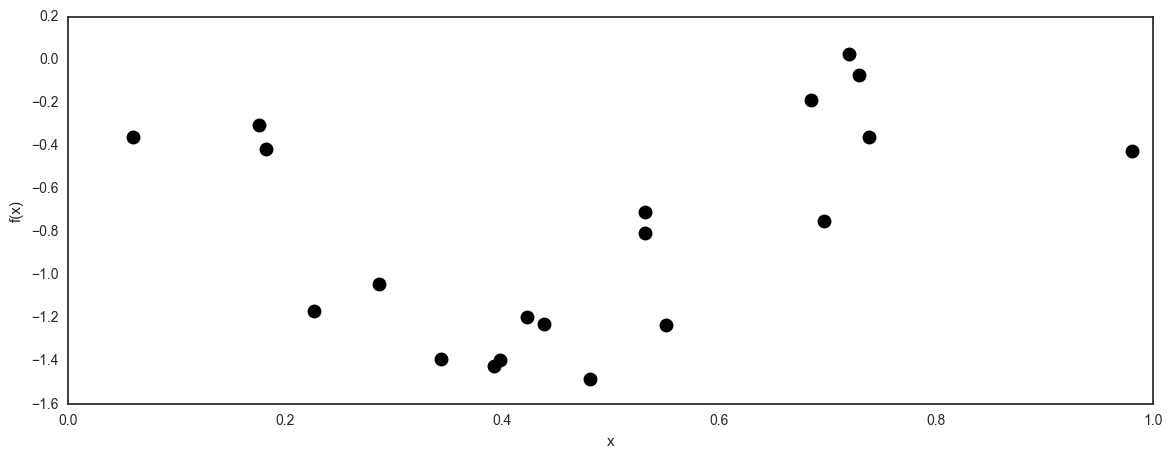

In [3]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(X, y, 'ok', ms=10);
ax.set_xlabel('x');
ax.set_ylabel('f(x)');

### Sample using elliptical slice sampling 

In [4]:
Z = np.linspace(0, 1, 100)[:, None]

with pm.Model() as model:
    # Covariance functions for the function f and the noise
    f_cov = f_var * pm.gp.cov.ExpQuad(1, lengthscale)
    n_cov = noise_var * tt.eye(n)

    # Sampled y values
    y_sample = pm.MvNormal('y_sample', mu=0, cov=f_cov.K(X) + n_cov, shape=n)

    # Likelihood
    y_obs = pm.MvNormal('y_obs', observed=y, mu=y_sample, cov=np.eye(n), shape=n)

    ## using deterministics for prediction
    K_inv = tt.nlinalg.matrix_inverse(K)
    K_s   = f_cov.K(X, Z)
    K_ss  = f_cov.K(Z, Z)

    f = pm.Deterministic("f", tt.dot(tt.dot(K_s.T, K_inv), y_sample))
    Sigma = pm.Deterministic("Sigma", K_ss - tt.dot(tt.dot(K_s.T, K_inv), K_s))
    start = pm.find_MAP(fmin=scipy.optimize.fmin_l_bfgs_b)
    step = pm.EllipticalSlice(prior_cov=f_cov.K(X) + n_cov)
    trace = pm.sample(5000, step=step, start=start)

100%|██████████| 5000/5000 [00:29<00:00, 169.60it/s]


### Show that samples provide a reasonably good fit given the small amount of data points

Distribution is narrower near the middle, wider near the end, more or less of the right shape, etc.

/Users/jonathanfriedman/anaconda3/envs/pymc3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: covariance is not positive-semidefinite.


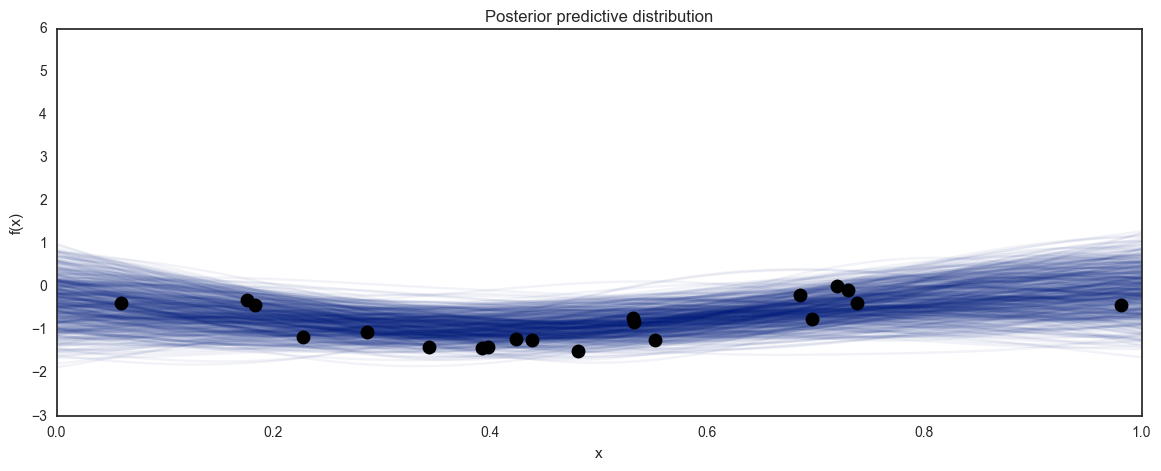

In [9]:
fig, ax = plt.subplots(figsize=(14, 5))

idx = np.random.randint(1000, 5000, 500)
for i, ix in enumerate(idx):
    S  = trace[ix]["Sigma"]
    mu = trace[ix]["f"]
    yz = np.random.multivariate_normal(mu, S)
    ax.plot(Z, yz, color=sns.color_palette('dark')[0], alpha=0.05)

# Overlay the observed data
ax.plot(X, y, 'ok', ms=10);
ax.set_xlabel("x");
ax.set_ylabel("f(x)");
ax.set_title("Posterior predictive distribution")
ax.set_ylim([-3, 6]);

### Plot some samples from the actual posterior for comparison

/Users/jonathanfriedman/anaconda3/envs/pymc3/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: covariance is not positive-semidefinite.


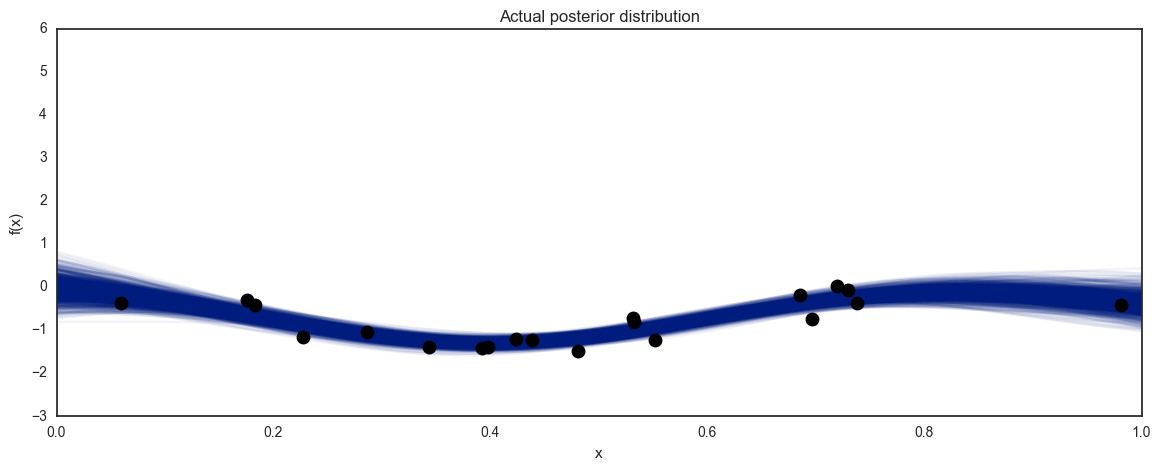

In [8]:
fig, ax = plt.subplots(figsize=(14, 5))

K_inv = np.linalg.inv(K)
K_s = cov.K(X, Z).eval()
K_ss = cov.K(Z, Z).eval()

mu = np.dot(np.dot(K_s.T, K_inv), y)
S = K_ss - np.dot(np.dot(K_s.T, K_inv), K_s)

for _ in range(1000):
    yz = np.random.multivariate_normal(mu, S)
    ax.plot(Z, yz, color=sns.color_palette('dark')[0], alpha=0.05)

# Overlay the observed data
ax.plot(X, y, 'ok', ms=10);
ax.set_xlabel("x");
ax.set_ylabel("f(x)");
ax.set_title("Actual posterior distribution")
ax.set_ylim([-3, 6]);